# United States flights reports Data exploration

## Preliminary Wrangling

This document explores a dataset with flights reports in the United States, including carriers, arrival and departure delays, and reasons for delays, for the year 2008.

In [1]:
# Importing all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sb
import calendar

%matplotlib inline

In [2]:
# Loading the dataset into a pandas dataframe, print statistics
delay = pd.read_csv(r'2008.csv')

In [3]:
# Creating a copy of the datframe before starting

delays = delay.copy()

In [4]:
# High-level overview of data shape and composition
print(delays.shape)

print(delays.info())

# Sample of the dataframe
print(delays.head(5))

# Descriptive statistics for numeric variables
print(delays.describe())

(2389217, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389217 entries, 0 to 2389216
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  Weat

In [5]:
print(delays.Month.unique())
print(delays.DayofMonth.unique())
print(delays.DayOfWeek.unique())
print(delays.CancellationCode.unique())

[1 2 3 4]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31  2  1]
[4 5 6 7 1 2 3]
[nan 'A' 'C' 'B' 'D']


In [6]:
print(len(delays.UniqueCarrier.unique()))
print(len(delays.Origin.unique()))
print(len(delays.Dest.unique()))

20
291
293


Months column seems incomplete so we will probably drop it later along with other columns that we will not use in the analysis.

The days of the week column is a numeric variable that we will probably need to convert to categorical with the week days names.

In [7]:
print(delays.ArrDelay.sort_values().head(60))
print(delays.DepDelay.sort_values().head(60))

262409    -91.0
1105417   -90.0
2115261   -89.0
1538674   -86.0
375193    -86.0
2384943   -86.0
1282865   -85.0
1341222   -81.0
1714864   -81.0
477557    -80.0
2333162   -80.0
760965    -79.0
1553531   -78.0
1598002   -78.0
2333188   -77.0
1339992   -76.0
533465    -75.0
1312429   -73.0
2323777   -73.0
417819    -72.0
158644    -72.0
2201793   -72.0
1343166   -72.0
478508    -71.0
1280895   -71.0
375069    -71.0
2318589   -71.0
526513    -71.0
1516831   -71.0
1715540   -70.0
154439    -70.0
1281790   -70.0
1342564   -69.0
751121    -69.0
602786    -69.0
1549749   -69.0
1539440   -69.0
1449559   -69.0
1105368   -68.0
357465    -68.0
167836    -68.0
318229    -68.0
1105750   -68.0
2333092   -67.0
1105222   -67.0
156308    -67.0
350507    -67.0
417584    -67.0
2313659   -67.0
543360    -66.0
880272    -66.0
358212    -66.0
166453    -66.0
167059    -66.0
276714    -66.0
1661171   -66.0
164439    -66.0
2202019   -65.0
314646    -65.0
417831    -65.0
Name: ArrDelay, dtype: float64
146421   

We notice above the negative values in the departure and arrival delays columns. Unfortunately there is not enough explanation from the data set provider. Arrival delays with negative values can be somehow explained as planes happen to arrive earlier. On the contrary, it is rare for a plane to depart earlier, at least in cases with more than 5-10 minutes. We will later filter our data set for negative values up to -60 for arrival delays and -5 for departure delays. We cn however, drop the columns we will not use for the analysis.

In [10]:
# Dropping columns that we will not use
col_to_drop = ['Year', 'Month', 'DepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'TaxiIn', 'TaxiOut', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
delays.drop(col_to_drop, 1, inplace = True)

### What is the structure of your dataset? 

There are 2389217 flight reports in the dataset with many flight information in 24 columns. The majority of the variables are numeric apart from the carrier or airline, the origin and destination airports and the cancelation code.

"UniqueCarrier" column contains 20 airlines
"Origin" column contains 291 origin airports
"Dest" column contains 293 destination airports and
"CancellationCode" column contains four cancelation codes A, B, C and D for CarrierDelay, WeatherDelay, NASDelay and LateAircraftDelay respectively.


### What is/are the main feature(s) of interest in your dataset?

I'm most interested in figuring out what features are related to flight cancellations and flight delays whether it is for departure or arrival delays

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that busy times of day, big and busy airports as well as the flight distance will be factors for flight delays. Also, some airlines might be associated with more frequent flight delays.

## Univariate Exploration


I'll start by looking at some general characteristics about the flights. I will look at the airlines first, and the number of the flights they accomodated. But before that let's replace the abbreviations with the full names.

In [12]:
# Replacing the abbreviations with the full names

delays['UniqueCarrierFull'] = delays['UniqueCarrier'].map({'WN': 'Southwest Airlines', 'XE': 'Expressjet Airlines', 'YV': 'Mesa Airlines',
                                                       'OH': 'Comair', 'OO': 'Skywest Airlines','UA': 'United Air Lines', 'US': 'US Airways',
                                                       'DL': 'Delta Air Lines', 'EV': 'Atlantic Southeast Airlines', 'F9': 'Frontier Airlines',
                                                       'FL': 'AirTran Airways', 'HA': 'Hawaiian Airlines', 'MQ': 'American Eagle Airlines',
                                                       'NW': 'Northwest Airlines', '9E': 'Pinnacle Airlines', 'AA': 'American Airlines', 
                                                       'AQ': 'Aloha Airlines', 'AS': 'Alaska Airlines', 'B6': 'JetBlue Airways', 'CO': 'Continental Air Lines'})

In [ ]:
# Dropping UniqueCarrier as it is no longer needed.

delays.drop(UniqueCarrier, 1, inplace = True)

Now we can plot.

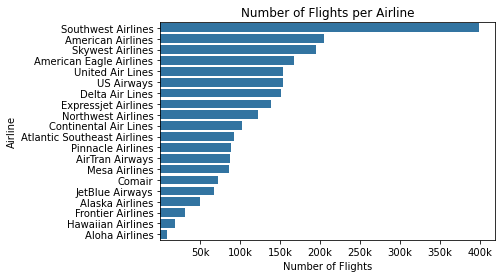

In [13]:
# Flights Per Airline (Barchart)

base_color = sb.color_palette()[0]

position = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000]
name = ['50k', '100k', '150k', '200k', '250k', '300k', '350k' ,'400k']

Carrier_Order = delays.UniqueCarrierFull.value_counts().index
sb.countplot(data = delays, y = 'UniqueCarrierFull', color = base_color, order = Carrier_Order)
plt.xlabel('Number of Flights')
plt.ylabel('Airline')
plt.xticks(position, name)
plt.title('Number of Flights per Airline');

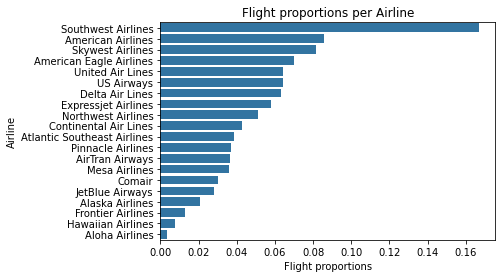

In [14]:
# We can as well plot it by proportion

n_flights = delays.shape[0]
max_carr_count = delays.UniqueCarrierFull.value_counts()[0]
max_prop = max_carr_count/n_flights

tick_props = np.arange(0,max_prop, 0.02)
tick_names = ['{:0.2f}'.format(v)for v in tick_props]

sb.countplot(data = delays, y = 'UniqueCarrierFull', color = base_color, order = Carrier_Order)
plt.xticks(tick_props * n_flights, tick_names)
plt.xlabel('Flight proportions')
plt.ylabel('Airline')
plt.title('Flight proportions per Airline');

Let's check now which are the busiest origin and destination airports. In order to do so and due to the large amount of the airports we will filter the dataset by the top five origin and destination airports by way of number of flights.

In [15]:
# Extract top five origin airports with most flights
origin_airport_flights = pd.Series(delays.groupby('Origin')['Origin'].count())
origin_airport_flights = origin_airport_flights.sort_values(ascending=False)
top_five = origin_airport_flights.index[:5]

# Subset to the top 5 origin airports
top_five_origin_airports = delays[delays['Origin'].isin(top_five)]

In [16]:
# Extract top five destination airports with most flights
destination_airport_flights = pd.Series(delays.groupby('Dest')['Dest'].count())
destination_airport_flights = destination_airport_flights.sort_values(ascending=False)
top_five = destination_airport_flights.index[:5]

# Subset to the top 5 destination airports
top_five_destination_airports = delays[delays['Dest'].isin(top_five)]

Now we can plot

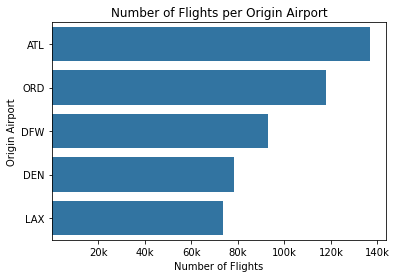

In [17]:
# Number of flights per Origin Airport (Barchart)

positions = [20000, 40000, 60000, 80000, 100000, 120000, 140000]
labels = ['20k', '40k', '60k', '80k', '100k', '120k', '140k']

Origin_Airport_Order = top_five_origin_airports.Origin.value_counts().index
sb.countplot(data = top_five_origin_airports, y = 'Origin', color = base_color, order = Origin_Airport_Order)
plt.xlabel('Number of Flights')
plt.ylabel('Origin Airport')
plt.xticks(positions, labels)
plt.title('Number of Flights per Origin Airport');

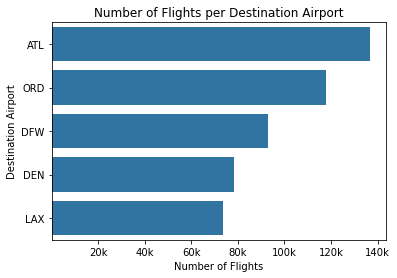

In [18]:
# Number of flights per Destination Airport (Barchart)

Destination_Airport_Order = top_five_destination_airports.Dest.value_counts().index
sb.countplot(data = top_five_destination_airports, y = 'Dest', color = base_color, order = Destination_Airport_Order)
plt.xlabel('Number of Flights')
plt.ylabel('Destination Airport')
plt.xticks(positions, labels)
plt.title('Number of Flights per Destination Airport');

We can already see that the busiest airport in terms of both departures and arrivals are the same five. We will later examine if these airports are associated with higher delays as well. 

Now we will check if certain days of the week or month have higher number of flights than others. We will start by the days of the week but in order to plot it correctly we will convert the numeric variable to categorical and ordered from Monday to Sunday as well.

In [19]:
# Mapping the days of the week and creating an ordered (by day) categorical type to tranform our variable into.
 
delays['DayOfWeek'] = delays['DayOfWeek'].map({1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
                                                 5: 'Friday', 6: 'Saturday', 7: 'Sunday'})

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']   
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = days)
delays['DayOfWeek'] = delays['DayOfWeek'].astype(ordered_var)

#check if everything is done correctly
delays['DayOfWeek'].dtype

CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'Saturday', 'Sunday'],
                 ordered=True)

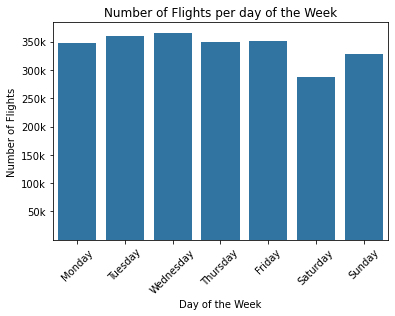

In [20]:
# Flights Per Day of Week (Barchart)

positions = [50000, 100000, 150000, 200000, 250000, 300000, 350000]
labels = ['50k', '100k', '150k', '200k', '250k', '300k', '350k']
sb.countplot(data = delays, x = 'DayOfWeek', color = base_color)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Flights')
plt.title('Number of Flights per day of the Week')
plt.yticks(positions, labels)
plt.xticks(rotation = 45);

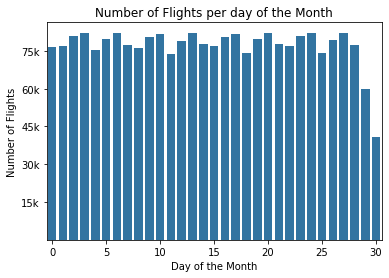

In [21]:
# Flights Per Day of Month (Barchart)

xpositions = [0, 5, 10, 15, 20, 25, 30]
xlabels = ['{:0.0f}'.format(v)for v in xpositions]
ypositions = [15000, 30000, 45000, 60000, 75000]
ylabels = ['15k', '30k', '45k', '60k', '75k']

sb.countplot(data = delays, x = 'DayofMonth', color = base_color)
plt.xlabel('Day of the Month')
plt.ylabel('Number of Flights')
plt.title('Number of Flights per day of the Month')
plt.xticks(xpositions, xlabels)
plt.yticks(ypositions, ylabels);

Not a lot of interesting insights here appart from Saturday seemingly being the day with the less flights of the week and 31st the day with the less flghts of the month.

Let's move forward and examine the proportion of cancelled flights in a pie chart.

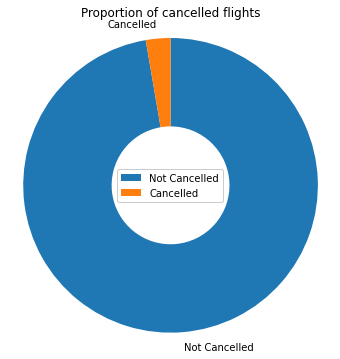

In [63]:
# Proportion of cancelled flights (Piechart)
plt.figure(figsize=(6, 6))
 
labels = ['Not Cancelled', 'Cancelled']
Cancelled = delays['Cancelled'].value_counts()
plt.pie(Cancelled, labels = labels, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6})
plt.legend(loc = 10, framealpha = 1)
plt.axis('square')
plt.title('Proportion of cancelled flights');

Let's now see the reasons of flight cancellations compared to each other. But before that let's change "A", "B", "C" and "D" to 'Carrier', 'Weather', 'NAS' and 'Security' respectively.

In [23]:
delays['CancellationCode'] = delays['CancellationCode'].map({'A': 'Carrier', 'B': 'Weather', 'C': 'NAS', 'D': 'Security'})

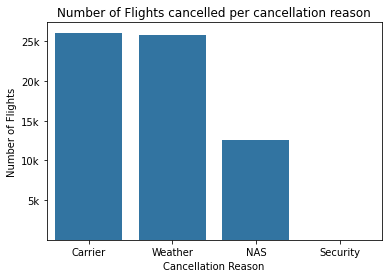

In [24]:
# Cancelled Reasons (Barchart)

positions = [5000, 10000, 15000, 20000, 25000]
labels = ['5k', '10k', '15k', '20k', '25k']
code_order = delays['CancellationCode'].value_counts().index

sb.countplot(data = delays, x = 'CancellationCode', color = base_color, order = code_order)
plt.xlabel('Cancellation Reason')
plt.ylabel('Number of Flights')
plt.title('Number of Flights cancelled per cancellation reason')
plt.yticks(positions, labels)
plt.xticks();

We can see that the most common reasons for flights cancellation are Airline delays and Weather conditions with Security being the rarest, almost non-existent reason.

I will now continue by looking at the distribution of the 2 main variable of interest: Arrival and departure delays.

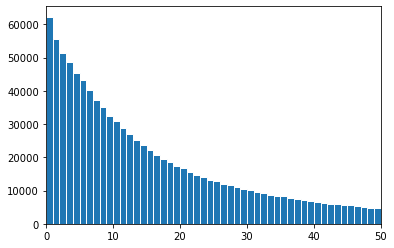

In [25]:
# Arrivals Delay in mins (Histogram)

bins = np.arange(-1, delays.ArrDelay.max()+1, 1)
plt.hist(data=delays, x = 'ArrDelay', bins = bins, edgecolor = 'white')
plt.xlim(0, 50);

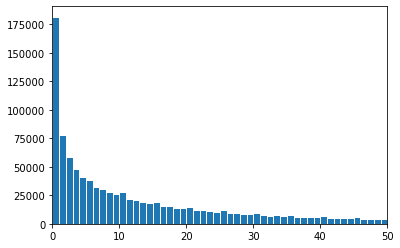

In [26]:
# Departures Delay in mins (Histogram)

bins = np.arange(-1, delays.DepDelay.max()+1, 1)
plt.hist(data=delays, x = 'DepDelay', bins = bins, edgecolor = 'white')
plt.xlim(0, 50);

We can see that both distributions are long tailed and highly skewed to the right, even after zooming in the most common flight delays time. There are a lot of flights with few minutes of delay and very few with a large number of minutes. We should, therefore, apply a logarithmic transformation to have a better look at the distribution. To perform the logarithmic transformation simpler, we will create and use a subset, filtering out of our data the negative arrival and departure delays values. We will also create another subset for convenience, filtering the negative values for arrival delays to be no less than -60 (an hour early arrival in other words) and for departure delays no more that -5 (5 minutes early departure)

In [27]:
# Creating a new subset containg only the flights with delays, the positive values in other words.

delaysonly = delays[(delays['ArrDelay'] > 0) & (delays['DepDelay'] > 0)]
delaysclean = delays[(delays['ArrDelay'] > -60) & (delays['DepDelay'] > -5)]

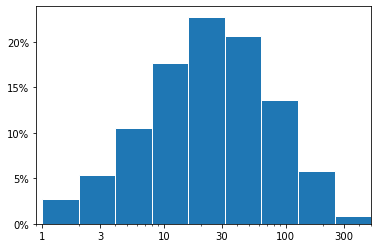

In [28]:
# Percenatges of Arrivals Delays in mins after logarithmic transformation (Histogram)

bins = 10 ** np.arange(0, 3.391112e+00+ 0.3, 0.3)
positions = [1, 3, 10, 30, 100, 300, 1000]
labels = ['{}'.format(v) for v in positions]
plt.hist(data=delaysonly, x = 'ArrDelay', bins = bins, edgecolor = 'white', weights=np.ones(len(delaysonly)) / len(delaysonly))
plt.xscale('log')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0 ))
plt.xticks(positions, labels)
plt.xlim(0.9, 500);

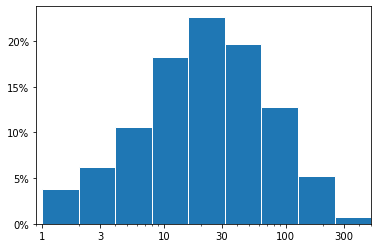

In [29]:
# Percenatges of Departures Delays in mins after logarithmic transformation (Histogram)

bins = 10 ** np.arange(0, 3.391112e+00+ 0.3, 0.3)
positions = [1, 3, 10, 30, 100, 300, 1000]
labels = ['{}'.format(v) for v in positions]
plt.hist(data=delaysonly, x = 'DepDelay', bins = bins, edgecolor = 'white',weights=np.ones(len(delaysonly)) / len(delaysonly))
plt.xscale('log')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0 ))
plt.xticks(positions, labels)
plt.xlim(0.9, 500);

We can see that after the logarithmic transformation the graph appears unimodal and the distribution normal centred roughly around 20 minutes.

We will now continue with the bivariate exploration.

## Bivariate

We will firstly try to answer the question on whether the numerical variables of our dataset are correlated in any way.

More specific. Are arrival and departure delays?

Let's try to answer it by plotting a scatterplot, of departure against arrival delays.

In [30]:
# We will take a sample as the scatterplot will be too dense otherwise due to the large number of datapoints

sample = np.random.choice(delays.shape[0], 200, replace = False)
sample = delays.loc[sample,:]

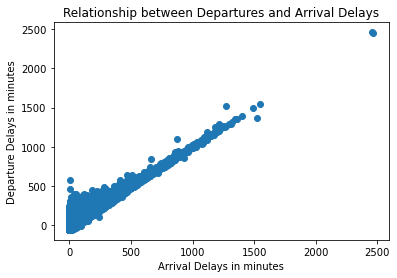

In [31]:
# Relationship between Departure and Arrival Delays (scatterplot)

plt.scatter(data = delaysclean, x = 'DepDelay', y = 'ArrDelay')
plt.xlabel('Arrival Delays in minutes')
plt.ylabel('Departure Delays in minutes')
plt.title('Relationship between Departures and Arrival Delays');

As expected, arrival and departure delays show a strong correlation.

Is airtime correlated with distance?

Let's plot next a scatterplot of airtime against distance.

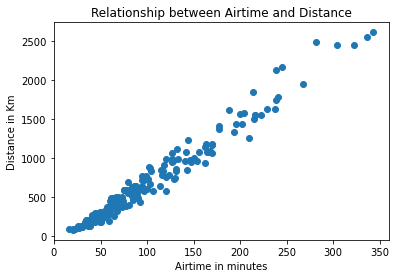

In [32]:
# Relationship between Airtime and Distance (scatterplot)

plt.scatter(data = sample, x = 'AirTime', y = 'Distance')
plt.xlabel('Airtime in minutes')
plt.ylabel('Distance in Km')
plt.title('Relationship between Airtime and Distance');

Again, as expected distance and airtime are highly correlated. The longer the airtime the longer the distance and vice versa.

How about arrival and departure delays relation with distance and airtime? Is there any correlation between these variables?

Let's plot to find out.

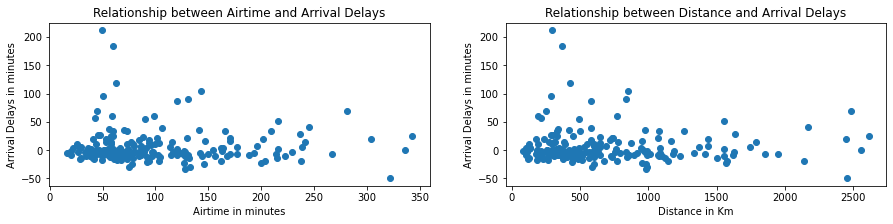

In [33]:
plt.figure(figsize=(15,3))

plt.subplot(1, 2, 1)
plt.scatter(data = sample, x = 'AirTime', y = 'ArrDelay')
plt.xlabel('Airtime in minutes')
plt.ylabel('Arrival Delays in minutes')
plt.title('Relationship between Airtime and Arrival Delays')

plt.subplot(1, 2, 2)
plt.scatter(data = sample, x = 'Distance', y = 'ArrDelay')
plt.xlabel('Distance in Km')
plt.ylabel('Arrival Delays in minutes')
plt.title('Relationship between Distance and Arrival Delays');

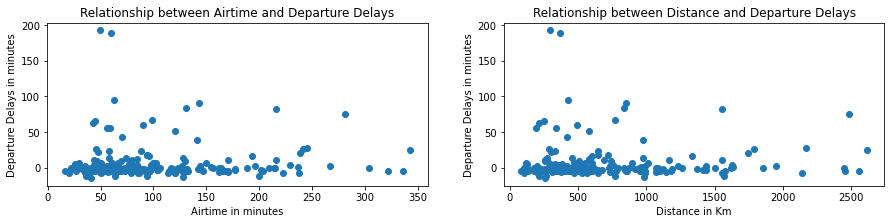

In [34]:
plt.figure(figsize=(15,3))

plt.subplot(1, 2, 1)
plt.scatter(data = sample, x = 'AirTime', y = 'DepDelay')
plt.xlabel('Airtime in minutes')
plt.ylabel('Departure Delays in minutes')
plt.title('Relationship between Airtime and Departure Delays');

plt.subplot(1, 2, 2)
plt.scatter(data = sample, x = 'Distance', y = 'DepDelay')
plt.xlabel('Distance in Km')
plt.ylabel('Departure Delays in minutes')
plt.title('Relationship between Distance and Departure Delays');

Surprisingly, neither airtime nor distance seem to affect any kind of delays a lot.

Since there is no strong relation between the variables of interest (arrival and departure delays) and the other two numeric variables, let's explore further the flight cancellations, starting from the relation between airline and flight cancellation.

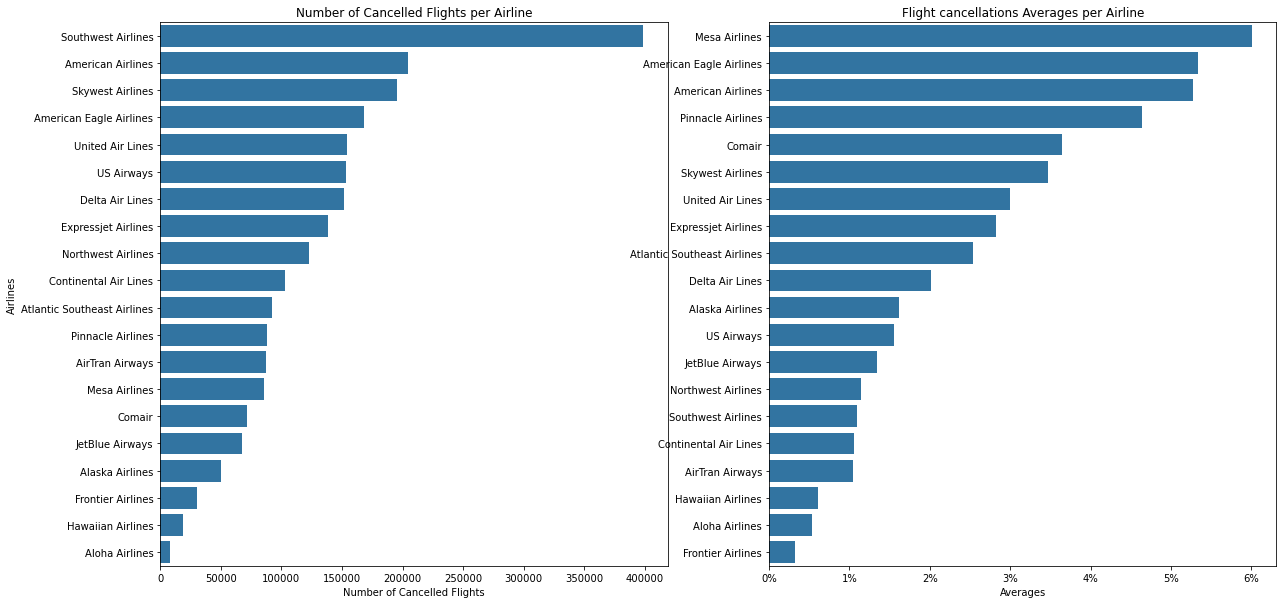

In [35]:
plt.figure(figsize=(20,10))

# Cancelled Flights Per Airline
plt.subplot(1, 2, 1)

AirlineCancellations = delays.groupby('UniqueCarrierFull').Cancelled.count().sort_values(ascending = False)
sb.barplot(x=AirlineCancellations.values,y=AirlineCancellations.index,color=base_color)
plt.xlabel('Number of Cancelled Flights')
plt.ylabel('Airlines')
plt.title('Number of Cancelled Flights per Airline')

# Cancelled Flights Percentages Per Airline
plt.subplot(1, 2, 2)

AvgCancellationsPerAirline = delays.groupby('UniqueCarrierFull').Cancelled.mean().sort_values(ascending = False)
sb.barplot(x=AvgCancellationsPerAirline.values,y=AvgCancellationsPerAirline.index,color=base_color)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1, decimals = 0))
plt.xlabel('Averages')
plt.ylabel(None)
plt.title('Flight cancellations Averages per Airline');

Southwest Airlines appears first in the number of cancelled flights; however, we've seen earlier that it is the Airline with the biggest number of flights by far. It is better to look at the averages where we see it ranks below the midpoint. On the other hand, Mesa Airlines is first in the averages table, while their number of flights is relatively low. Pinnacle Airlines is a similar case, with high average ranking and lower flight count ranking which is certainly not a good sign for their image. American Eagle and American Airlines have both high ranking in both tables and Hawaiian, Aloha and Frontier Airlines, appear to be the airlines with the low delays’ averages, but very low number of flights too.

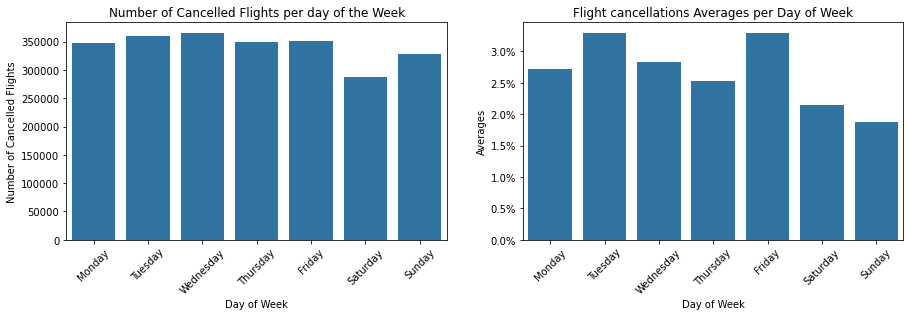

In [36]:
plt.figure(figsize=(15,4))

# Cancelled Flights Per Day of Week
plt.subplot(1, 2, 1)

DoWCancellations = delays.groupby('DayOfWeek').Cancelled.count()

sb.barplot(x=DoWCancellations.index,y=DoWCancellations.values,color=base_color)
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Number of Cancelled Flights')
plt.title('Number of Cancelled Flights per day of the Week');

# Cancelled Flights Averages Per Day of Week
plt.subplot(1, 2, 2)

AvgCancellationsPerDoW = delays.groupby('DayOfWeek').Cancelled.mean()

sb.barplot(x=AvgCancellationsPerDoW.index,y=AvgCancellationsPerDoW.values,color=base_color)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals = 1))
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Averages')
plt.title('Flight cancellations Averages per Day of Week');

Tuesday and Friday appear to be the days with the highest cancellation averages while at the same time weekends seem to have the lowest

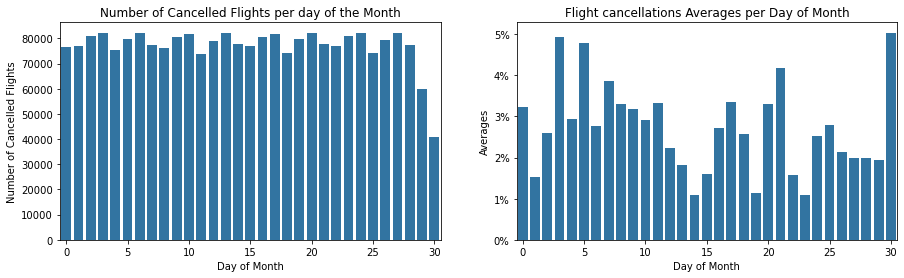

In [37]:
plt.figure(figsize=(15,4))

# Cancelled Flights Per Day of Week
plt.subplot(1, 2, 1)

DoMCancellations = delays.groupby('DayofMonth').Cancelled.count()

sb.barplot(x=DoMCancellations.index,y=DoMCancellations.values,color=base_color)
plt.xticks([0,5,10,15,20,25,30], [0,5,10,15,20,25,30])
plt.xlabel('Day of Month')
plt.ylabel('Number of Cancelled Flights')
plt.title('Number of Cancelled Flights per day of the Month');

# Cancelled Flights Averages Per Day of Month
plt.subplot(1, 2, 2)

AvgCancellationsPerDoM = delays.groupby('DayofMonth').Cancelled.mean()

sb.barplot(x=AvgCancellationsPerDoM.index,y=AvgCancellationsPerDoM.values,color=base_color)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals = 0))
plt.xticks([0,5,10,15,20,25,30], [0,5,10,15,20,25,30])
plt.xlabel('Day of Month')
plt.ylabel('Averages')
plt.title('Flight cancellations Averages per Day of Month');

Here we notice the last day of the month showing the lowest count of cancelled flights but at the same time the highest percentage too. The low number of cancellations can be explained by the low number of flights we have seen earlier in this analysis. One other thing that we can notice is that the second half of the month seems to show relatively lower percentages of cancellations.

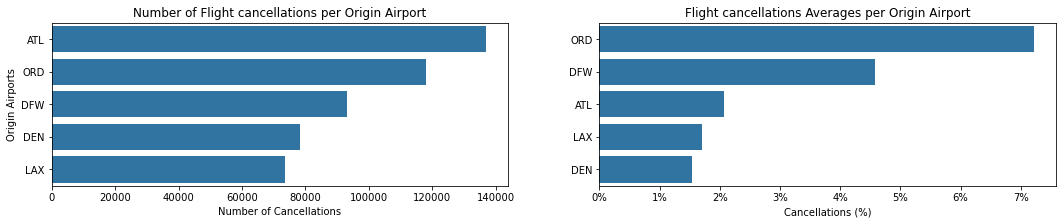

In [38]:
plt.figure(figsize=(18,3))

# Cancelled Flights Per Day of Week
plt.subplot(1, 2, 1)

CancellationsCountPerOrAirports = top_five_origin_airports.groupby('Origin').Cancelled.count().sort_values(ascending = False)

sb.barplot(x=CancellationsCountPerOrAirports.values,y=CancellationsCountPerOrAirports.index,color=base_color)
plt.xlabel('Number of Cancellations')
plt.ylabel('Origin Airports')
plt.title('Number of Flight cancellations per Origin Airport');

# Cancelled Flights Averages Per Day of Month
plt.subplot(1, 2, 2)

AvgCancellationsPerOrAirports = top_five_origin_airports.groupby('Origin').Cancelled.mean().sort_values(ascending = False)

sb.barplot(x=AvgCancellationsPerOrAirports.values,y=AvgCancellationsPerOrAirports.index,color=base_color);
plt.gca().xaxis.set_major_formatter(PercentFormatter(1, decimals = 0))
plt.xlabel('Cancellations (%)')
plt.ylabel(None)
plt.title('Flight cancellations Averages per Origin Airport');

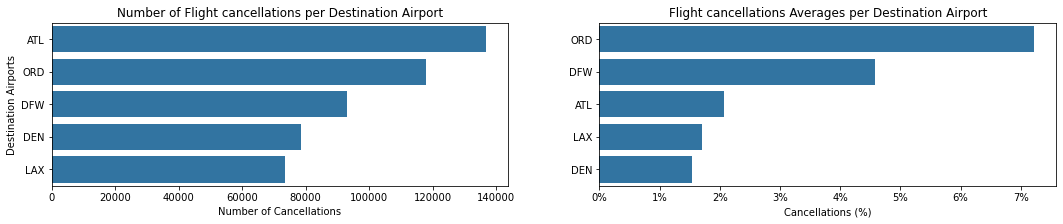

In [39]:
plt.figure(figsize=(18,3))

# Cancelled Flights Per Day of Week
plt.subplot(1, 2, 1)

CancellationsCountPerDestAirports = top_five_destination_airports.groupby('Dest').Cancelled.count().sort_values(ascending = False)

sb.barplot(x=CancellationsCountPerDestAirports.values,y=CancellationsCountPerDestAirports.index,color=base_color)
plt.xlabel('Number of Cancellations')
plt.ylabel('Destination Airports')
plt.title('Number of Flight cancellations per Destination Airport');

# Cancelled Flights Averages Per Day of Month
plt.subplot(1, 2, 2)

AvgCancellationsPerDestAirports = top_five_destination_airports.groupby('Dest').Cancelled.mean().sort_values(ascending = False)

sb.barplot(x=AvgCancellationsPerOrAirports.values,y=AvgCancellationsPerOrAirports.index,color=base_color);
plt.gca().xaxis.set_major_formatter(PercentFormatter(1, decimals = 0))
plt.xlabel('Cancellations (%)')
plt.ylabel(None)
plt.title('Flight cancellations Averages per Destination Airport');

Regarding the top 5 busiest airports we notice a similar trend. William B. Hartsfield-Atlanta International Airport is first at number of cancellations but third in average cancellation with a lower percentage of more than half the percentage of the second airport of Dallas/Fort Worth International Airport. On the other hand, Chicago O'Hare International Airport, is first at averages and second at number of cancellations with a relatively high number.

Let's now look at the arrival and departure delays. How much, airlines, airports, day of month and day of week impact the flight delays? Let's find out.

This time we will use the filtered dataset that we created before for arrival delays values up to -60 and for departure delays values up to -5. 

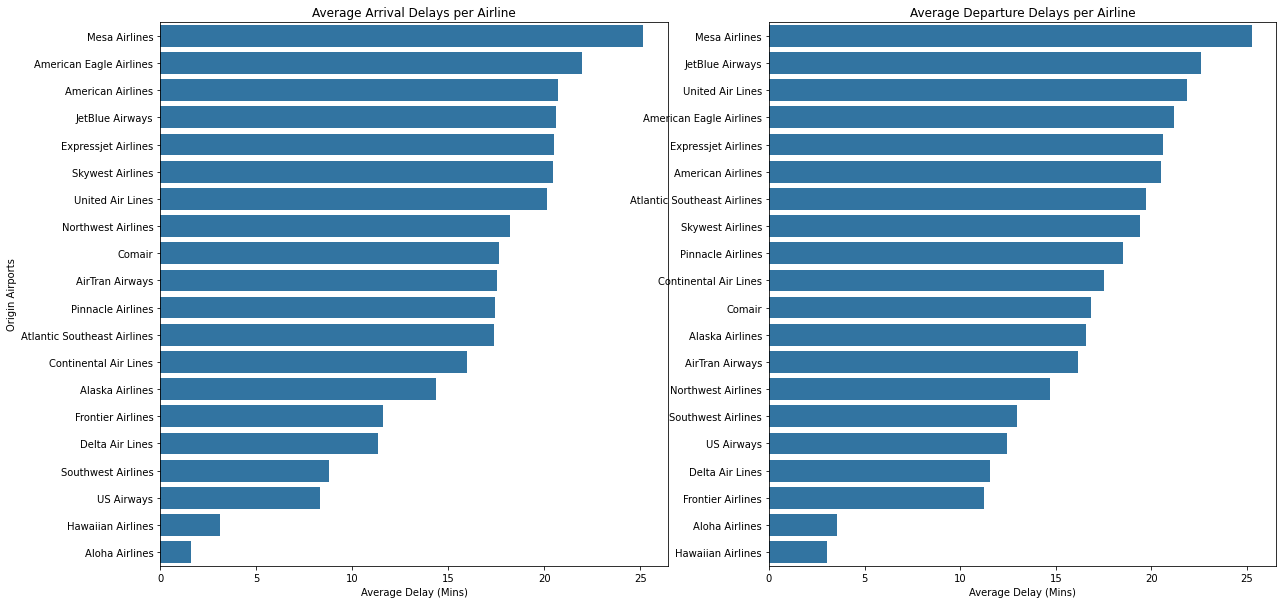

In [40]:
plt.figure(figsize=(20,10))

# Arrival Delays Averages Per Airline

plt.subplot(1, 2, 1)

ArrivalDelaysPerAirline = delaysclean.groupby('UniqueCarrierFull').ArrDelay.mean().sort_values(ascending=False)

sb.barplot(x=ArrivalDelaysPerAirline.values,y=ArrivalDelaysPerAirline.index,color=base_color)
plt.xlabel('Average Delay (Mins)')
plt.ylabel('Origin Airports')
plt.title("Average Arrival Delays per Airline");

# Departure Delays Averages Per Airline

plt.subplot(1, 2, 2)

DepartureDelaysPerAirline = delaysclean.groupby('UniqueCarrierFull').DepDelay.mean().sort_values(ascending=False)

sb.barplot(x=DepartureDelaysPerAirline.values,y=DepartureDelaysPerAirline.index,color=base_color)
plt.xlabel('Average Delay (Mins)')
plt.ylabel(None)
plt.title('Average Departure Delays per Airline');

Here we notice the two ends of the graphs, that are the same in both Arrivals and Departures. Mesa Airlines, in the higher end, seems to be the Airline that experiences the most delays out of all airlines, and on the other hand in the lower end, Hawaiian and Aloha Airlines seem to have the lowest delays out of all the airlines.

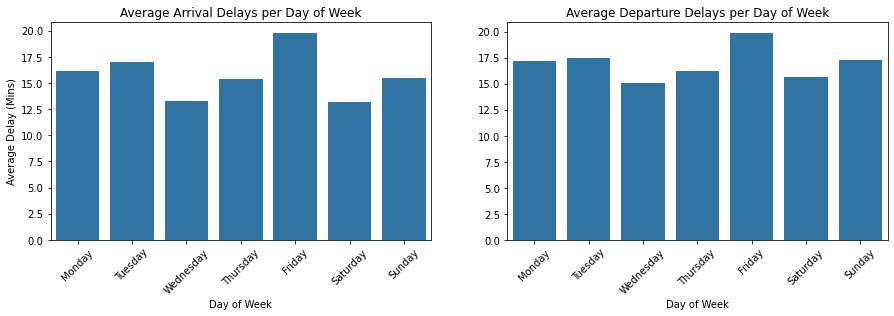

In [66]:
plt.figure(figsize=(15,4))
# Arrival Delays Averages Per Day of the Week

plt.subplot(1, 2, 1)

MeanArrDelaysPerDoW = delaysclean.groupby('DayOfWeek')['ArrDelay'].mean()

sb.barplot(x=MeanArrDelaysPerDoW.index,y=MeanArrDelaysPerDoW.values,color=base_color)

plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Average Delay (Mins)')
plt.title('Average Arrival Delays per Day of Week')

# Departure Delays Averages Per Day of the Week

plt.subplot(1, 2, 2)

MeanDepDelaysPerDoW = delaysclean.groupby('DayOfWeek')['DepDelay'].mean()

sb.barplot(x=MeanDepDelaysPerDoW.index,y=MeanDepDelaysPerDoW.values,color=base_color)

plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel(None)
plt.title('Average Departure Delays per Day of Week');

We find Fridays and Thursdays once again in the first two places, with Monday a close third. The departure delays are more evenly spread across days while arrival delays show a slightly different image. Wednesdays and Saturdays are in relatively better place with slightly lower arrival delays than the other days.

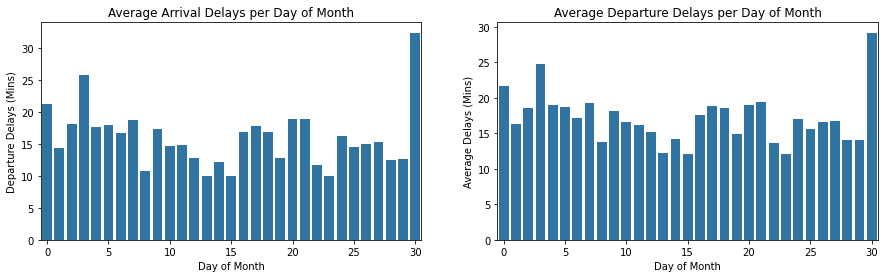

In [42]:
plt.figure(figsize=(15,4))

# Arrival Delays Averages Per Day of Month

plt.subplot(1, 2, 1)

MeanArrDelaysPerDoM = delaysclean.groupby('DayofMonth')['ArrDelay'].mean()

sb.barplot(x=MeanArrDelaysPerDoM.index,y=MeanArrDelaysPerDoM.values,color=base_color)

#plt.xticks(rotation = 45)
plt.xticks([0,5,10,15,20,25,30], [0,5,10,15,20,25,30])
plt.xlabel('Day of Month')
plt.ylabel('Departure Delays (Mins)')
plt.title('Average Arrival Delays per Day of Month');

plt.subplot(1, 2, 2)
# Departure Delays Averages Per Day of Month

MeanDepDelaysPerDoM = delaysclean.groupby('DayofMonth')['DepDelay'].mean()

sb.barplot(x=MeanDepDelaysPerDoM.index,y=MeanDepDelaysPerDoM.values,color=base_color)

#plt.xticks(rotation = 45)
plt.xticks([0,5,10,15,20,25,30], [0,5,10,15,20,25,30])
plt.xlabel('Day of Month')
plt.ylabel('Average Delays (Mins)')
plt.title('Average Departure Delays per Day of Month');

Departure delays appear slightly higher throughout the month, but generally speaking the variation of delay is similar to both departure and arrival delays. The last day of the month shows the longest delays while the first and fourth days are second and third longest.

Let's move on to the next variable to plot against delays. Let's see the busiest airports and how much delays are affected by certain airports.

Let's re-code the top-5 airports for flights with negative delays values for arrivals up to -60 and departures up to -5. 

In [43]:
# Extract top five origin airports with most flights
origin_airport_flights = pd.Series(delaysclean.groupby('Origin')['Origin'].count())
origin_airport_flights = origin_airport_flights.sort_values(ascending=False)
top_five = origin_airport_flights.index[:5]

# Subset to the top 5 origin airports
top_five_origin_airports_sub = delaysclean[delaysclean['Origin'].isin(top_five)]

# Extract top five destination airports with most flights
destination_airport_flights = pd.Series(delaysclean.groupby('Dest')['Dest'].count())
destination_airport_flights = destination_airport_flights.sort_values(ascending=False)
top_five = destination_airport_flights.index[:5]

# Subset to the top 5 destination airports
top_five_destination_airports_sub = delaysclean[delaysclean['Dest'].isin(top_five)]

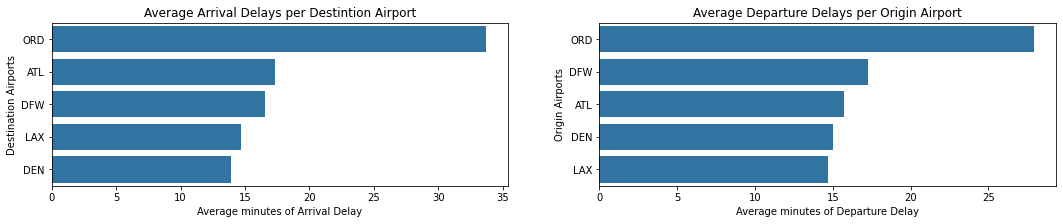

In [44]:
plt.figure(figsize=(18,3))

#Arrival Delays Averages Per Top-Five Destination Airports

plt.subplot(1, 2, 1)

MeanDelayPerDestAirports = top_five_destination_airports_sub.groupby('Dest').ArrDelay.mean().sort_values(ascending = False)

sb.barplot(x=MeanDelayPerDestAirports.values,y=MeanDelayPerDestAirports.index,color=base_color)
plt.xlabel('Average minutes of Arrival Delay')
plt.ylabel('Destination Airports')
plt.title('Average Arrival Delays per Destintion Airport');

# Arrival Delays Averages Per Top-Five Destination Airports

plt.subplot(1, 2, 2)

MeanDelayPerOrAirports = top_five_origin_airports_sub.groupby('Origin').DepDelay.mean().sort_values(ascending = False)

sb.barplot(x=MeanDelayPerOrAirports.values,y=MeanDelayPerOrAirports.index,color=base_color);
plt.xlabel('Average minutes of Departure Delay')
plt.ylabel('Origin Airports')
plt.title('Average Departure Delays per Origin Airport');

Chicago O'Hare International Airport is first again in average delays as well. This time things look even worse. The average delay compared to the other airports is far greater, with arrival delays being more than double and departure delays almost double. The other four airports are very close to one another with Los Angeles and Denver International airports showing the shortest delays of the five.

Now, it would be a good idea to examine whether the time of the flight plays a role at flights being delayed. In order to do so we will engineer a new variable dividing flight times in three categories per popularity level. 8:00 - 16:00 will represent the most popular time slot, 16:00 - 00:00 the second most popular and 00:00 - 08:00 the least popular.

We will also engineer one more variable in order to categorize delays from Minor to Major as follows. Minor Delays will be delays less than 5 minutes, Significant delays will be delays from 5 to 60 minutes and Major delays will be delays from 60 minutes and more.

In the next cells we will use lambda functions in order to set the levels, map the returned numbers to names and convert them to category type, setting their orders as well.

In [45]:
PopTimes_mod = lambda x:((0,1)[x > 800],2)[x > 1600]
delaysclean['TimePopularityLvl'] = delaysclean['CRSDepTime'].apply(PopTimes_mod)

C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
delaysclean['TimePopularityLvl'] = delaysclean['TimePopularityLvl'].map({0:'Least Popular', 1:'Most Popular', 2:'2nd Most Popular'})

TimePopTypes = ['Most Popular', '2nd Most Popular', 'Least Popular']   
Ordered_TimePop_Type = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = TimePopTypes)
delaysclean['TimePopularityLvl'] = delaysclean['TimePopularityLvl'].astype(Ordered_TimePop_Type)

C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
ArrDelay_mod = lambda x:((0,1)[x > 5],2)[x > 60]
delaysclean['ArrDelayLevel'] = delaysclean['ArrDelay'].apply(ArrDelay_mod)

C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
DepDelay_mod = lambda x:((0,1)[x > 5],2)[x > 60]
delaysclean['DepDelayLevel'] = delaysclean['DepDelay'].apply(DepDelay_mod)

C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
delaysclean['ArrDelayLevel'] = delaysclean['ArrDelayLevel'].map({0:'Minor Delay', 1:'Significant Delay', 2:'Major Delay'})

delaysclean['DepDelayLevel'] = delaysclean['DepDelayLevel'].map({0:'Minor Delay', 1:'Significant Delay', 2:'Major Delay'})

DelayTypes = ['Minor Delay', 'Significant Delay', 'Major Delay']   
Ordered_Delay_Type = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = DelayTypes)

delaysclean['ArrDelayLevel'] = delaysclean['ArrDelayLevel'].astype(Ordered_Delay_Type)

delaysclean['DepDelayLevel'] = delaysclean['DepDelayLevel'].astype(Ordered_Delay_Type)

C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

We are now ready to plot a clustered bar chart and explore the relation between the time of the travel and the delays. Do popular time slots lead to more frequent delays? Let's find out.

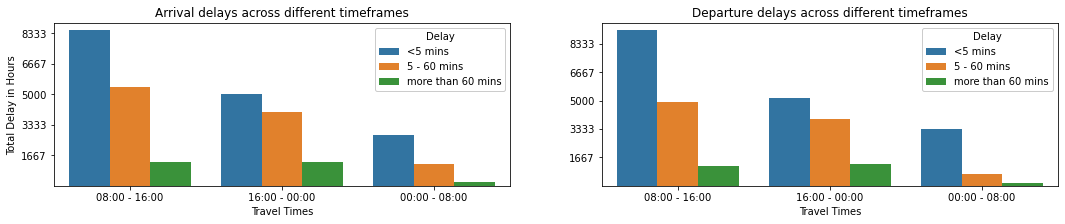

In [50]:
plt.figure(figsize=(18,3))

# Arrival "Delay Levels" Per Level of Travel Times Popularity

position = [0,1,2]
names = ['08:00 - 16:00', '16:00 - 00:00', '00:00 - 08:00' ]
yposition = [100000, 200000, 300000, 400000, 500000]
ynames = [round(i/60) for i in yposition]
plt.subplot(1, 2, 1)

sb.countplot(data = delaysclean, x = 'TimePopularityLvl', hue = 'ArrDelayLevel')
plt.xlabel('Travel Times')
plt.ylabel('Total Delay in Hours')
plt.xticks(position, names)
plt.yticks(yposition, ynames)
plt.title('Arrival delays across different timeframes')
plt.legend(title='Delay', loc=1, labels=['<5 mins', '5 - 60 mins', 'more than 60 mins'],framealpha = 1)

# Departure "Delay Levels" Per Level of Travel Times Popularity

plt.subplot(1, 2, 2)

sb.countplot(data = delaysclean, x = 'TimePopularityLvl', hue = 'DepDelayLevel')
plt.xlabel('Travel Times')
plt.ylabel(None)
plt.xticks(position, names)
plt.yticks(yposition, ynames)
plt.title('Departure delays across different timeframes')
plt.xticks(position, names)
plt.legend(title='Delay', loc=1, labels=['<5 mins', '5 - 60 mins', 'more than 60 mins'],framealpha = 1);

As expected, there is a definite relation there. Minor delays occur much more often between 08:00 and 16:00, significant delays too but the relation here is not that strong, but the interesting thing to observe here is that major delays between 16:00 and 00:00 seem to occur just as much as between 08:00 and 16:00, if not more.

It is worth plotting the same data on a heatmap too, so we can better see how major delays compare from the most to second most popular travel timeframe.

In order to do so we need to do some summarization work and some data pivoting to be able to plot the data.

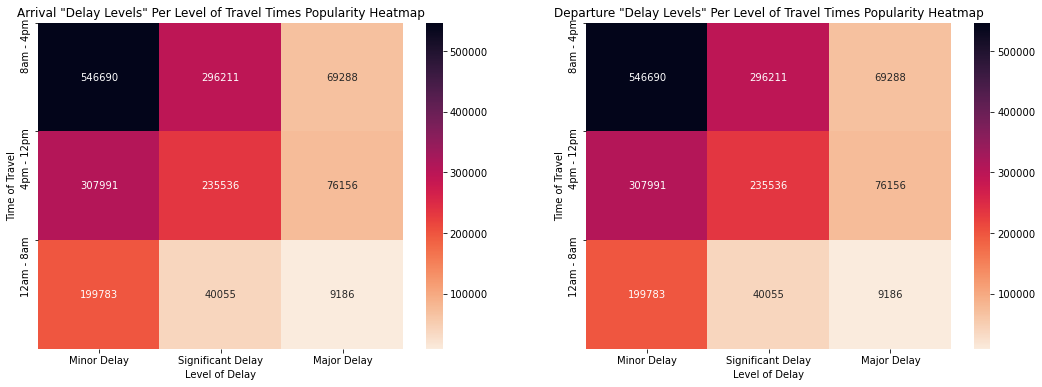

In [51]:
plt.figure(figsize=(18,6))

# Summarizing and pivoting
delay_counts = delaysclean.groupby(['TimePopularityLvl', 'ArrDelayLevel']).size()
delay_counts.reset_index(name = 'count')
delay_counts = delay_counts.unstack()

delay_counts = delaysclean.groupby(['TimePopularityLvl', 'DepDelayLevel']).size()
delay_counts.reset_index(name = 'count')
delay_counts = delay_counts.unstack()

# Plotting
plt.subplot(1, 2, 1)

sb.heatmap(delay_counts, annot = True, fmt = 'd', cmap = 'rocket_r')
plt.xlabel('Level of Delay')
plt.ylabel('Time of Travel')
plt.yticks([0,1,2],['8am - 4pm', '4pm - 12pm', '12am - 8am'])
plt.title('Arrival "Delay Levels" Per Level of Travel Times Popularity Heatmap')

plt.subplot(1, 2, 2)

sb.heatmap(delay_counts, annot = True, fmt = 'd', cmap = 'rocket_r')
plt.xlabel('Level of Delay')
plt.ylabel('Time of Travel')
plt.yticks([0,1,2],['8am - 4pm', '4pm - 12pm', '12am - 8am'])
plt.title('Departure "Delay Levels" Per Level of Travel Times Popularity Heatmap');

Text(0.5, 1.0, 'Arrival "Delay Levels" Per Level of Travel Times Popularity Heatmap')

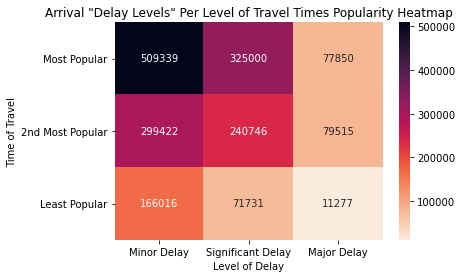

In [52]:
plt.figure(figsize=(6,4))

# Summarizing and pivoting
delay_counts = delaysclean.groupby(['TimePopularityLvl', 'ArrDelayLevel']).size()
delay_counts.reset_index(name = 'count')
delay_counts = delay_counts.unstack()

# Plotting
sb.heatmap(delay_counts, annot = True, fmt = 'd', cmap = 'rocket_r')
plt.xlabel('Level of Delay')
plt.ylabel('Time of Travel')
plt.title('Arrival "Delay Levels" Per Level of Travel Times Popularity Heatmap')

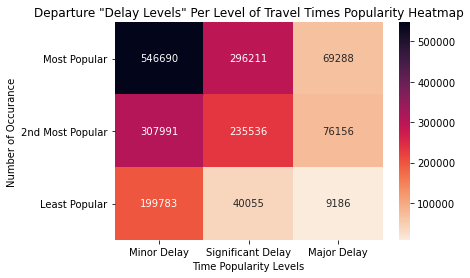

In [53]:
plt.figure(figsize=(6,4))

# Summarizing and pivoting
delay_counts = delaysclean.groupby(['TimePopularityLvl', 'DepDelayLevel']).size()
delay_counts.reset_index(name = 'count')
delay_counts = delay_counts.unstack()

# Plotting
sb.heatmap(delay_counts, annot = True, fmt = 'd', cmap = 'rocket_r')
plt.xlabel('Time Popularity Levels')
plt.ylabel('Number of Occurance')
plt.title('Departure "Delay Levels" Per Level of Travel Times Popularity Heatmap');

Indeed, by viewing the heatmaps with the annotations we can see clearly both visually and numerically that more major delays were observed during the timeframe from 16:00 to 00:00 than the most popular one from 08:00 to 16:00.
That is an interesting and rather surprizing find.

## Multivariate

Since airlines, origin and destination airports, day of the week and of the month, all seem to impact flight delays let's explore more than two at once this time.

Let's look the relation between airlines and destination airport and the average arrival delay, and between airlines and origin airport and the average departure delay.

We will again need to summarize and pivot our data like before first.

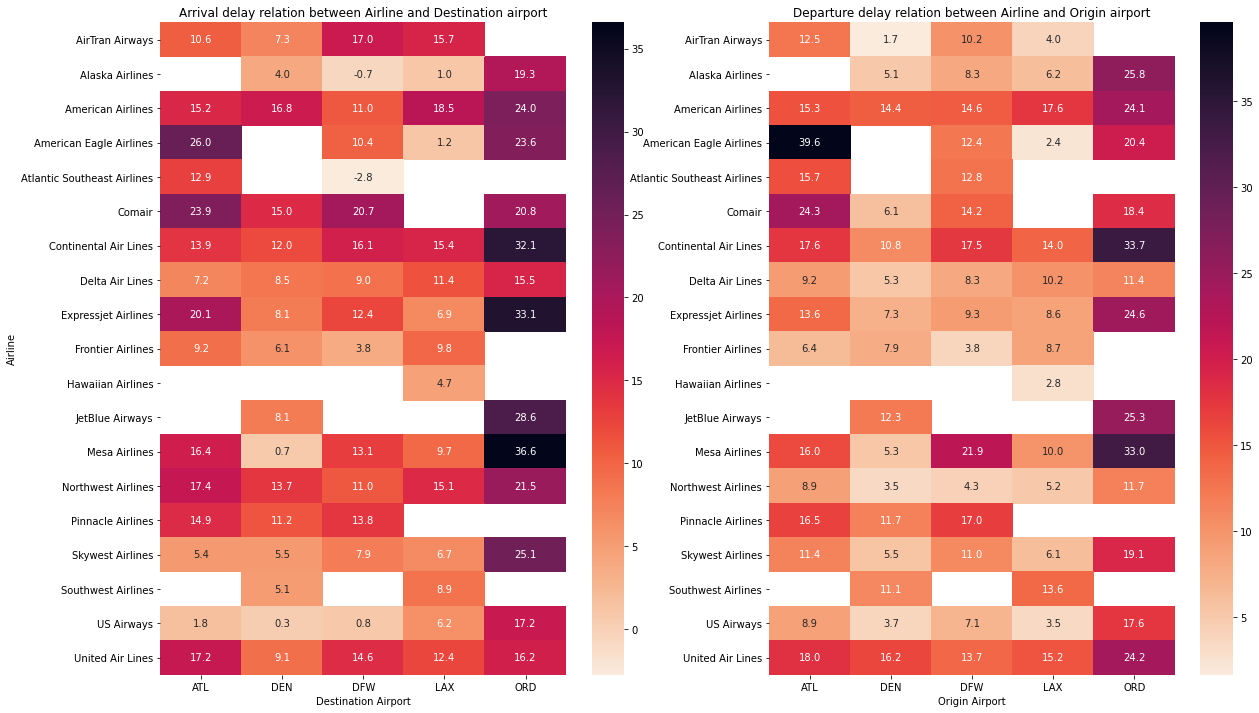

In [54]:
plt.figure(figsize=(20,12))

# Summarizing and pivoting

TopFiveOrgnAirprts = top_five_origin_airports.groupby(['UniqueCarrierFull', 'Origin'])['DepDelay'].mean()
TopFiveOrgnAirprts.reset_index(name = 'count')
TopFiveOrgnAirprts = TopFiveOrgnAirprts.unstack()

TopFiveDestAirprts = top_five_destination_airports.groupby(['UniqueCarrierFull', 'Dest'])['ArrDelay'].mean()
TopFiveDestAirprts.reset_index(name = 'count')
TopFiveDestAirprts = TopFiveDestAirprts.unstack()

# Plotting

plt.subplot(1, 2, 1)
sb.heatmap(TopFiveDestAirprts, annot = True, fmt=".1f", cmap = 'rocket_r')
plt.title('Arrival delay relation between Airline and Destination airport')
plt.xlabel('Destination Airport')
plt.ylabel('Airline')

plt.subplot(1, 2, 2)
sb.heatmap(TopFiveOrgnAirprts, annot = True, fmt=".1f", cmap = 'rocket_r')
plt.title('Departure delay relation between Airline and Origin airport')
plt.xlabel('Origin Airport')
plt.ylabel(None);

From this heatmap we notice that Chicago O'Hare International Airport has the darker data points and thus the longer average delays with Atlanta International Airport having the second darkest data points. However, the highest delay average is in Atlanta too and more specific from American Eagle Airlines. The highest arrival delay is observed at Chicago O'Hare International from Mesa Airline. 

It is obvious that delays are affected by the combination of airline and airport as for example Mesa Airlines average arrival delay is almost 0. This is a quite large difference from the highest observed average arrival delay of over 36 minutes we've seen earlier. We can easily spot similar observations all over the table. Another example is the other highest average we've seen earlier, the one for departure delays from American Eagle Airlines with almost 40 minutes at Atlanta International Airport when at Denver International Airport their average is 0 and at Los Angeles International Airport less than 2,5.

Let's create the Time Popularity Levels columns for the top 5 origin and destination airports subsets too, in order to examine the relation of the different times of flights with the different airports.

In [55]:
PopTimes_mod = lambda x:((0,1)[x > 800],2)[x > 1600]
top_five_origin_airports['TimePopularityLvl'] = top_five_origin_airports['CRSDepTime'].apply(PopTimes_mod)

C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
PopTimes_mod = lambda x:((0,1)[x > 800],2)[x > 1600]
top_five_destination_airports['TimePopularityLvl'] = top_five_destination_airports['CRSDepTime'].apply(PopTimes_mod)

C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
top_five_origin_airports['TimePopularityLvl'] = top_five_origin_airports['TimePopularityLvl'].map({0:'Least Popular', 1:'Most Popular', 2:'2nd Most Popular'})

top_five_origin_airports['TimePopularityLvl'] = delaysclean['TimePopularityLvl'].astype(Ordered_TimePop_Type)

C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
top_five_destination_airports['TimePopularityLvl'] = top_five_destination_airports['TimePopularityLvl'].map({0:'Least Popular', 1:'Most Popular', 2:'2nd Most Popular'})

top_five_destination_airports['TimePopularityLvl'] = top_five_destination_airports['TimePopularityLvl'].astype(Ordered_TimePop_Type)

C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\afled\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


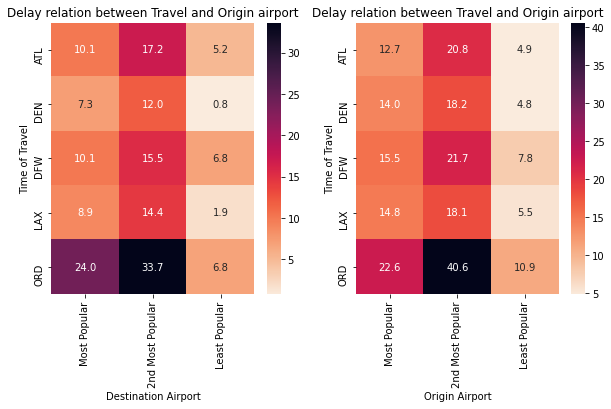

In [69]:
plt.figure(figsize=(10,5))

# Summarizing and pivoting

TopFiveOrgnAirprts = top_five_origin_airports.groupby(['Origin', 'TimePopularityLvl'])['DepDelay'].mean()
TopFiveOrgnAirprts.reset_index(name = 'count')
TopFiveOrgnAirprts = TopFiveOrgnAirprts.unstack()

TopFiveDestAirprts = top_five_destination_airports.groupby(['Dest', 'TimePopularityLvl'])['ArrDelay'].mean()
TopFiveDestAirprts.reset_index(name = 'count')
TopFiveDestAirprts = TopFiveDestAirprts.unstack()

# Plotting

plt.subplot(1, 2, 1)
sb.heatmap(TopFiveDestAirprts, annot = True, fmt=".1f", cmap = 'rocket_r')
plt.title('Delay relation between Travel and Origin airport')
plt.xlabel('Destination Airport')
plt.ylabel('Time of Travel')

plt.subplot(1, 2, 2)
sb.heatmap(TopFiveOrgnAirprts, annot = True, fmt=".1f", cmap = 'rocket_r')
plt.title('Delay relation between Travel and Origin airport')
plt.xlabel('Origin Airport')
plt.ylabel('Time of Travel');

There is a very interesting observation out of this heatmap. There are significantly higher delay averages in all five airports during the second most popular travel timeframe between 16:00 and 00:00 than the most popular travel timeframe between 00:00 and 08:00. 

This makes us wonder whether the initial assumption that the timeframe between 08:00 and 16:00 is indeed the most popular.

To investigate further let's see the average delays from airport to airport during the three timeframes.

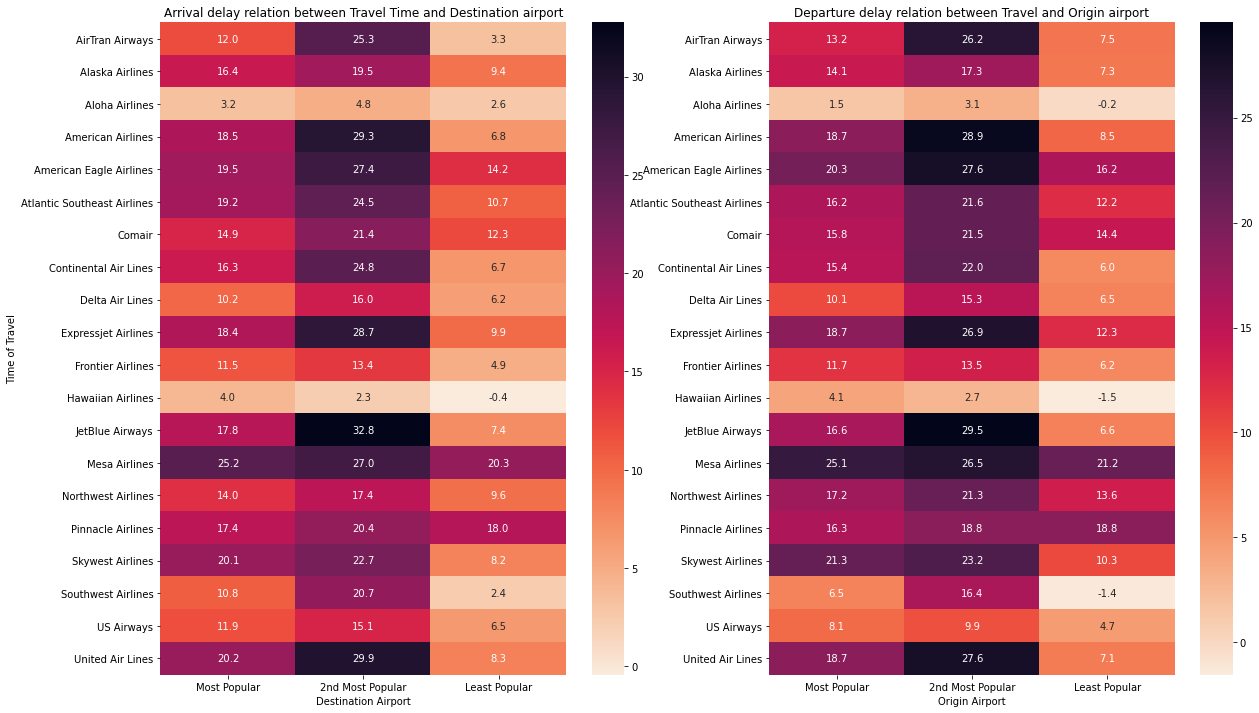

In [71]:
plt.figure(figsize=(20,12))

# Summarizing and pivoting

AirlinesDelayLvlDep = delaysclean.groupby(['UniqueCarrierFull', 'TimePopularityLvl'])['DepDelay'].mean()
AirlinesDelayLvlDep.reset_index(name = 'count')
AirlinesDelayLvlDep = AirlinesDelayLvlDep.unstack()

AirlinesDelayLvlArr = delaysclean.groupby(['UniqueCarrierFull', 'TimePopularityLvl'])['ArrDelay'].mean()
AirlinesDelayLvlArr.reset_index(name = 'count')
AirlinesDelayLvlArr = AirlinesDelayLvlArr.unstack()

# Plotting

plt.subplot(1, 2, 1)
sb.heatmap(AirlinesDelayLvlDep, annot = True, fmt=".1f", cmap = 'rocket_r')
plt.title('Arrival delay relation between Travel Time and Destination airport')
plt.xlabel('Destination Airport')
plt.ylabel('Time of Travel')

plt.subplot(1, 2, 2)
sb.heatmap(AirlinesDelayLvlArr, annot = True, fmt=".1f", cmap = 'rocket_r')
plt.title('Departure delay relation between Travel and Origin airport')
plt.xlabel('Origin Airport')
plt.ylabel(None);

The same thing is observed out of this heatmap as well. Higher average delays during the second most popular timeframe at the vast majority of airports too.

The two last plots make us wonder whether the initial assumption that the timeframe between 08:00 and 16:00 is indeed the most popular one is true.

We can plot a final heatmap to see the number of flights per timeframe and find out.

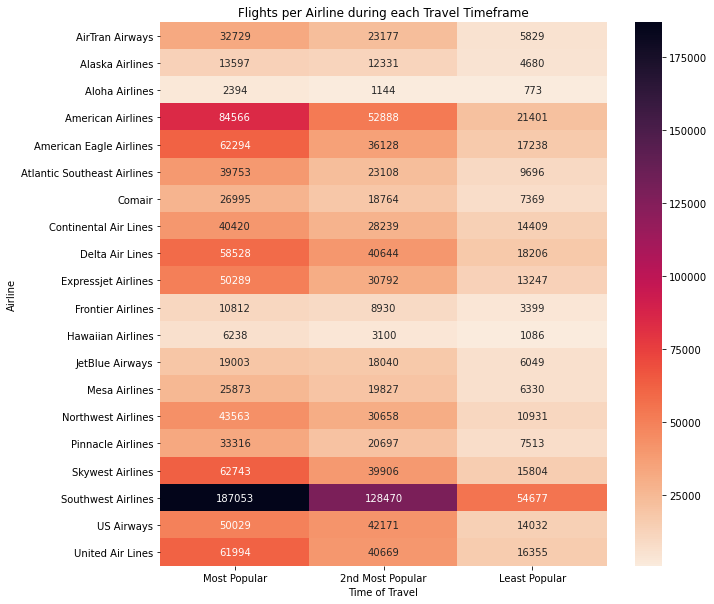

In [61]:
# Plotting the number of flights for each Airline divided in the three time frames

plt.figure(figsize=(10,10));

FlightsPerTimeLevelCount = round(delaysclean.groupby(['UniqueCarrierFull', 'TimePopularityLvl']).size())

FlightsPerTimeLevelCount.reset_index(name = 'count')
FlightsPerTimeLevelCount = FlightsPerTimeLevelCount.unstack()

sb.heatmap(FlightsPerTimeLevelCount, annot = True, fmt=".0f", cmap = 'rocket_r')
plt.title('Flights per Airline during each Travel Timeframe')
plt.ylabel('Airline')
plt.xlabel('Time of Travel');

Finally, the assumption proves correct since we can clearly see that most flights take place during the time frame from 08:00 - 16:00.